In [1]:
import pandas as pd
df = pd.read_csv("../data/Detalles_clientes.csv",index_col=False)

In [2]:
df['valor'] = df['valor'].astype(str).str.replace("'", "")
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df['clase'] = df['clase'].astype('category')
df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], format='%Y%m%d')

2025-08-14 14:52:40,479 - INFO - Inicio del proceso de segmentación de clientes.
2025-08-14 14:52:40,479 - INFO - Iniciando la ingeniería de características (Feature Engineering)...
2025-08-14 14:52:40,495 - INFO - Ingeniería de características completada.
2025-08-14 14:52:40,508 - INFO - Determinando el número óptimo de clusters (k)...


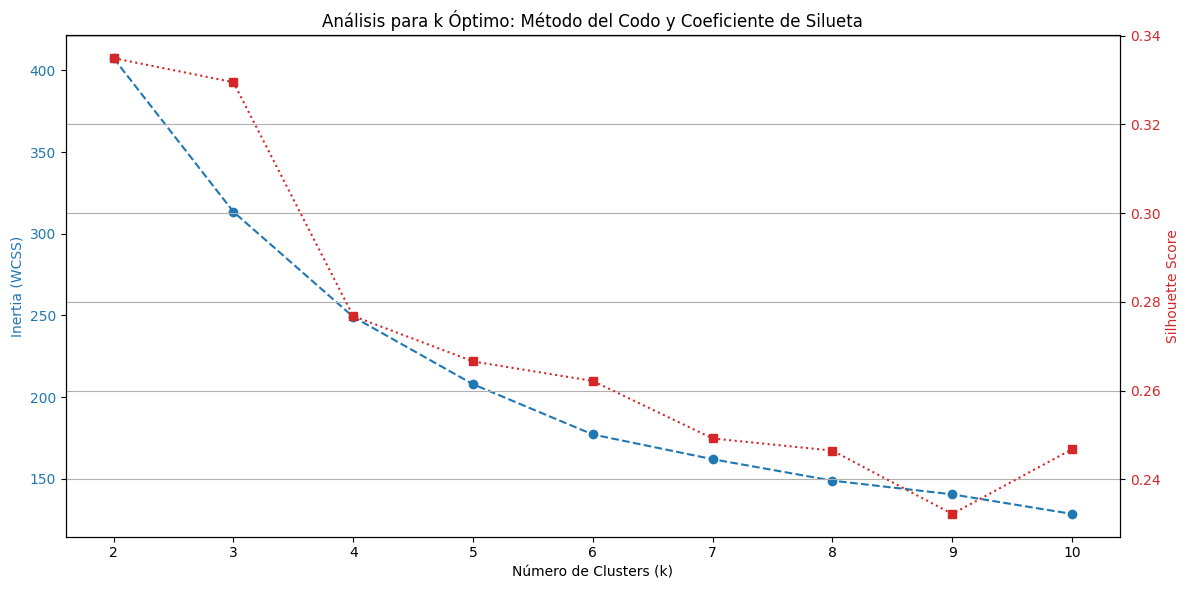

2025-08-14 14:52:43,023 - INFO - Entrenando modelo K-Means con k=4...
2025-08-14 14:52:43,125 - INFO - Perfilando los clusters...


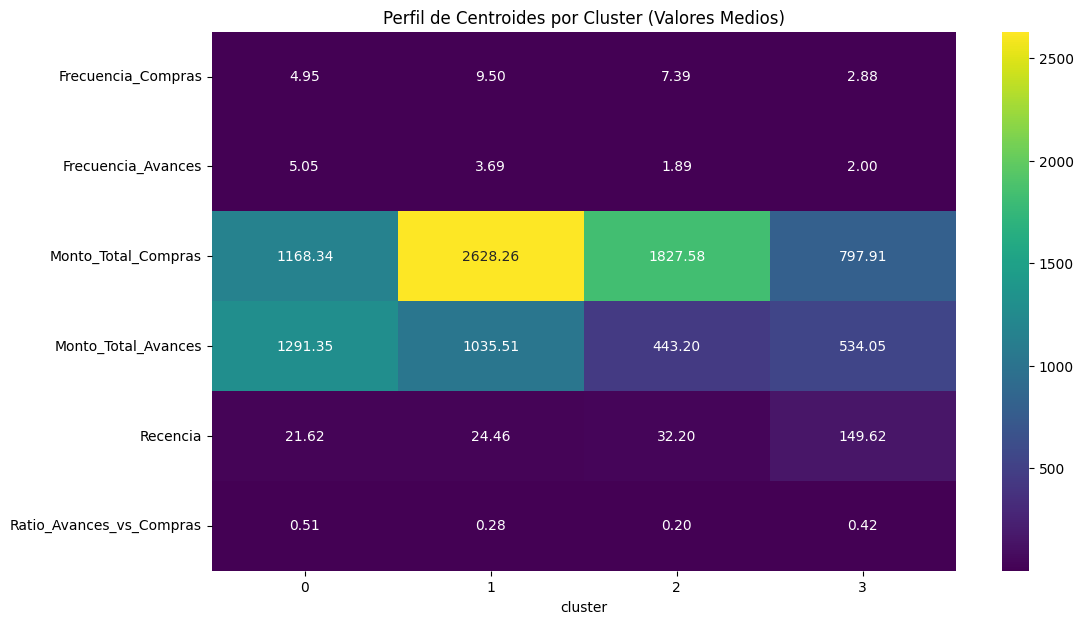

2025-08-14 14:52:43,372 - INFO - Asignación de estrategia de descuento completada.
2025-08-14 14:52:43,374 - INFO - Generando entregable final en 'estrategia_segmentacion_clientes.csv'...
2025-08-14 14:52:43,382 - INFO - Archivo guardado exitosamente.



--- Vista Previa del Entregable Final ---
   Id_cliente  cluster                           perfil_cluster  \
0           1        2                  Compradores Ocasionales   
1           2        2                  Compradores Ocasionales   
2           3        0  Clientes de Riesgo/Enfocados en Avances   
3           4        1                          Clientes Leales   
4           5        3                        Clientes Dormidos   
5           6        1                          Clientes Leales   
6           7        0  Clientes de Riesgo/Enfocados en Avances   
7           8        1                          Clientes Leales   
8           9        0  Clientes de Riesgo/Enfocados en Avances   
9          10        2                  Compradores Ocasionales   

   descuento_asignado  
0                0.05  
1                0.05  
2                0.20  
3                0.00  
4                0.25  
5                0.00  
6                0.20  
7                0.00  
8  

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict, List, Tuple

# --- Configuración del Logging ---
# Usar logging en lugar de print para un control profesional de los mensajes de salida.
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Parámetros de Configuración Centralizada ---
# Centralizar parámetros facilita la modificación y el mantenimiento del script.
CONFIG = {
    "features": [
        'Frecuencia_Compras', 'Frecuencia_Avances', 
        'Monto_Total_Compras', 'Monto_Total_Avances', 
        'Recencia', 'Ratio_Avances_vs_Compras'
    ],
    "k_range": range(2, 11),
    "optimal_k": 4,
    "random_state": 42,
    "output_filename": "estrategia_segmentacion_clientes.csv"
}

def run_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforma el DataFrame de transacciones en un DataFrame a nivel de cliente.

    Args:
        df: DataFrame con el historial de transacciones.

    Returns:
        DataFrame con métricas agregadas por cliente.
    """
    logging.info("Iniciando la ingeniería de características (Feature Engineering)...")
    
    df['fecha_efectiva'] = pd.to_datetime(df['fecha_efectiva'], unit='s')

    # Pivotar para obtener frecuencia y monto por tipo de transacción
    df_pivot = df.pivot_table(
        index='Id_cliente', 
        columns='clase', 
        values='valor', 
        aggfunc=['count', 'sum']
    ).fillna(0)
    df_pivot.columns = ['Frecuencia_Avances', 'Frecuencia_Compras', 'Monto_Total_Avances', 'Monto_Total_Compras']

    # Calcular Recencia
    fecha_corte = df['fecha_efectiva'].max()
    df_recencia = df.groupby('Id_cliente')['fecha_efectiva'].max().to_frame()
    df_recencia['Recencia'] = (fecha_corte - df_recencia['fecha_efectiva']).dt.days
    
    # Ensamblar el DataFrame final de clientes
    df_clientes = df_pivot.join(df_recencia[['Recencia']])
    
    # Calcular métricas derivadas
    total_transacciones = df_clientes['Frecuencia_Avances'] + df_clientes['Frecuencia_Compras']
    df_clientes['Ratio_Avances_vs_Compras'] = (df_clientes['Frecuencia_Avances'] / total_transacciones).fillna(0)
    
    logging.info("Ingeniería de características completada.")
    return df_clientes

def find_and_visualize_optimal_k(X_scaled: np.ndarray, config: Dict):
    """
    Calcula y visualiza las métricas para encontrar el número óptimo de clusters.

    Args:
        X_scaled: Datos estandarizados para el clustering.
        config: Diccionario de configuración.
    """
    logging.info("Determinando el número óptimo de clusters (k)...")
    k_range = config["k_range"]
    inertia = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=config["random_state"], n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

    # Crear visualización combinada
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Gráfico del Codo
    ax1.set_xlabel('Número de Clusters (k)')
    ax1.set_ylabel('Inertia (WCSS)', color='tab:blue')
    ax1.plot(k_range, inertia, marker='o', linestyle='--', color='tab:blue', label='Inertia')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Gráfico de Silueta en el mismo eje Y
    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score', color='tab:red')
    ax2.plot(k_range, silhouette_scores, marker='s', linestyle=':', color='tab:red', label='Silhouette Score')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Análisis para k Óptimo: Método del Codo y Coeficiente de Silueta')
    plt.grid(True)
    fig.tight_layout()
    plt.show()

def profile_and_assign_strategy(df_clientes: pd.DataFrame, config: Dict) -> pd.DataFrame:
    """
    Entrena el modelo K-Means, perfila los clusters y asigna la estrategia de descuento.

    Args:
        df_clientes: DataFrame con las características de los clientes.
        config: Diccionario de configuración.

    Returns:
        DataFrame final con la asignación de cluster y descuento.
    """
    logging.info(f"Entrenando modelo K-Means con k={config['optimal_k']}...")
    X = df_clientes[config["features"]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Entrenar modelo final
    kmeans = KMeans(n_clusters=config['optimal_k'], random_state=config['random_state'], n_init=10)
    df_clientes['cluster'] = kmeans.fit_predict(X_scaled)
    
    logging.info("Perfilando los clusters...")
    # Perfilado basado en los centroides (datos no escalados para interpretación)
    cluster_profile = df_clientes.groupby('cluster')[config["features"]].mean()
    
    # Visualización de los centroides para una fácil comparación
    plt.figure(figsize=(12, 7))
    sns.heatmap(cluster_profile.T, annot=True, fmt='.2f', cmap='viridis')
    plt.title('Perfil de Centroides por Cluster (Valores Medios)')
    plt.show()

    # Lógica de asignación de perfiles y descuentos
    # Esta lógica es más robusta al basarse en el ranking de los centroides
    sorted_recencia = cluster_profile['Recencia'].sort_values(ascending=False).index
    sorted_ratio_avance = cluster_profile['Ratio_Avances_vs_Compras'].sort_values(ascending=False).index
    sorted_compras = cluster_profile['Monto_Total_Compras'].sort_values(ascending=False).index

    perfil_map = {
        sorted_recencia[0]: "Clientes Dormidos",  # Mayor recencia
        sorted_ratio_avance[0]: "Clientes de Riesgo/Enfocados en Avances", # Mayor ratio de avances
        sorted_compras[0]: "Clientes Leales", # Mayor monto de compras
    }
    # El cluster restante se asigna al perfil por defecto
    default_profile = "Compradores Ocasionales"
    for c in cluster_profile.index:
        if c not in perfil_map:
            perfil_map[c] = default_profile

    descuento_map = {
        "Clientes Dormidos": 0.25,
        "Clientes de Riesgo/Enfocados en Avances": 0.20,
        "Compradores Ocasionales": 0.05,
        "Clientes Leales": 0.00
    }

    df_clientes['perfil_cluster'] = df_clientes['cluster'].map(perfil_map)
    df_clientes['descuento_asignado'] = df_clientes['perfil_cluster'].map(descuento_map)
    
    logging.info("Asignación de estrategia de descuento completada.")
    return df_clientes

def main():
    """
    Orquesta el flujo completo del proceso de segmentación de clientes.
    """
    logging.info("Inicio del proceso de segmentación de clientes.")
    
    # En un caso real, aquí se cargarían los datos.
    # df = pd.read_csv('ruta/a/tus/datos.csv')
    # Para demostración, se asume que 'df' existe, como en el entorno original.
    if 'df' not in globals():
        logging.error("El DataFrame 'df' no fue encontrado. Cargue los datos antes de ejecutar.")
        return

    df_clientes_featured = run_feature_engineering(df)
    
    # Escalar datos para análisis de k
    X_scaled = StandardScaler().fit_transform(df_clientes_featured[CONFIG["features"]])
    find_and_visualize_optimal_k(X_scaled, CONFIG)
    
    df_final = profile_and_assign_strategy(df_clientes_featured, CONFIG)
    
    # Preparar y guardar el entregable final
    entregable = df_final[['cluster', 'perfil_cluster', 'descuento_asignado']].reset_index()
    
    logging.info(f"Generando entregable final en '{CONFIG['output_filename']}'...")
    print("\n--- Vista Previa del Entregable Final ---")
    print(entregable.head(10))
    
    try:
        entregable.to_csv(CONFIG['output_filename'], index=False)
        logging.info("Archivo guardado exitosamente.")
    except Exception as e:
        logging.error(f"No se pudo guardar el archivo: {e}")

if __name__ == '__main__':
    # Se asume que 'df' ya está cargado. Si no, se debe cargar aquí.
    # Ejemplo de creación de 'df' para que el script sea ejecutable:
    data_demo = {
        'Id_cliente': np.random.randint(1, 100, 1000),
        'fecha_efectiva': np.random.randint(1720972800, 1752595200, 1000),
        'Id_tx': range(1000),
        'clase': np.random.choice(['COMPRA', 'AVANCE'], 1000, p=[0.7, 0.3]),
        'valor': np.random.uniform(10, 500, 1000)
    }
    df = pd.DataFrame(data_demo)
    
    main()
